In [1]:
import os, json
from transformers import AutoTokenizer
from layoutlmft.data.image_utils import RandomResizedCropAndInterpolationWithTwoPic, pil_loader, Compose
from torchvision import transforms
import torch
from timm.data.constants import IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from layoutlmft.data.image_utils import load_image, normalize_bbox
tokenizer = AutoTokenizer.from_pretrained(
    "./layoutlmv3-base-1028",
    use_fast=True,
)
common_transform = Compose([
    # transforms.ColorJitter(0.4, 0.4, 0.4),
    # transforms.RandomHorizontalFlip(p=0.5),
    RandomResizedCropAndInterpolationWithTwoPic(
        size=224, interpolation="bicubic"),
])
mean = IMAGENET_INCEPTION_MEAN
std = IMAGENET_INCEPTION_STD
patch_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=torch.tensor(mean),
        std=torch.tensor(std))
])
def normalize_bbox(bbox, size):
    return [
        int(1000 * bbox[0] / size[0]),
        int(1000 * bbox[1] / size[1]),
        int(1000 * bbox[2] / size[0]),
        int(1000 * bbox[3] / size[1]),
    ]

def get_line_bbox(bboxs):
        x = [bboxs[i][j] for i in range(len(bboxs)) for j in range(0, len(bboxs[i]), 2)]
        y = [bboxs[i][j] for i in range(len(bboxs)) for j in range(1, len(bboxs[i]), 2)]

        x0, y0, x1, y1 = min(x), min(y), max(x), max(y)

        assert x1 >= x0 and y1 >= y0
        bbox = [[x0, y0, x1, y1] for _ in range(len(bboxs))]
        return bbox

def generate_examples(self, filepath, img_dir):
    ann_dir = file_path
    img_dir = os.path.join(img_dir, "images")
    for guid, file in enumerate(sorted(os.listdir(ann_dir))):
        tokens = []
        bboxes = []
        ner_tags = []
        file_path = os.path.join(ann_dir, file)
        with open(file_path, "r", encoding="utf8") as f:
            data = json.load(f)
        image_path = os.path.join(img_dir, file)
        image_path = image_path.replace("json", "png")
        image, size = load_image(image_path)
        max_word_id = data["doc"][-1]["words"][-1]["id"]
        word_id_to_entity_label = [-1] * (max_word_id + 1)
        for entity in data["entities"]:
            entity_label = entity["label"].upper()
            for word_id in entity["word_idx"]:
                word_id_to_entity_label[word_id] = entity_label
        for word_id in range(len(word_id_to_entity_label)):
            if word_id_to_entity_label[word_id] == -1:
                word_id_to_entity_label[word_id] = "O"
        assert np.array(word_id_to_entity_label == -1).sum() == 0
        tokens_word_id = []
        for item in data["doc"]:
            cur_line_bboxes = []
            words = item["words"]
            words = [w for w in words if w["text"].strip() != "" or w["text"] == "<unk>"]
            if len(words) == 0:
                continue
            for w in words:
                tokens.append(w["text"])
                tokens_word_id.append(w["id"])
                cur_line_bboxes.append(normalize_bbox(w["box"], size))
            # by default: --segment_level_layout 1
            # if do not want to use segment_level_layout, comment the following line
            cur_line_bboxes = self.get_line_bbox(cur_line_bboxes)
            bboxes.extend(cur_line_bboxes)
        
        for word_id in tokens_word_id:
            if word_id_to_entity_label[word_id] == "O":
                ner_tags.append("O")
            else:
                if word_id == 0 or word_id_to_entity_label[word_id - 1] != word_id_to_entity_label[word_id]:
                    ner_tags.append("B-" + word_id_to_entity_label[word_id])
                else:
                    ner_tags.append("I-" + word_id_to_entity_label[word_id])
        
        yield guid, {"id": str(guid), "tokens": tokens, "bboxes": bboxes, "ner_tags": ner_tags,
                     "image": image, "image_path": image_path}

/root/mambaforge/envs/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset
import layoutlmft.data.funsd_ner, layoutlmft.data.custom_ner
import os
import pyarrow
pyarrow.PyExtensionType.set_auto_load(True)
funsd_dataset = load_dataset(os.path.abspath(layoutlmft.data.funsd_ner.__file__))
custom_dataset = load_dataset(os.path.abspath(layoutlmft.data.custom_ner.__file__))

/root/mambaforge/envs/env/lib/python3.8/site-packages/datasets/features/features.py:648: FutureWarning: pyarrow.PyExtensionType is deprecated and will refuse deserialization by default. Instead, please derive from pyarrow.ExtensionType and implement your own serialization mechanism.
  pa.PyExtensionType.__init__(self, self.storage_dtype)


# Compare ner taggings of two datasets

In [20]:
funsd_example = funsd_dataset["train"][2]
custom_example = custom_dataset["train"][2]

In [21]:
print(funsd_example["tokens"])
print(funsd_example["ner_tags"])

['DATE:', 'INITIATED', 'BY:', 'COMPLETION', 'COUNTRY:', 'PRODUCT:', 'BELGIUM', 'BY:', 'DATE:', 'NOTES:', '620429480', 'RECEIVED', 'SERVICE', 'REQUEST', 'FROM', 'R', '&', 'D', 'BY', 'INTERNATIONAL', 'LICENSEE', 'OPERATIONS', 'REQUEST', 'NO.:', '25-', '84', 'March', '27,', '1984', 'P.', 'H.', 'HARPER', 'PHH', 'TARGET', 'DATE:', 'April', '13,', '1984', 'LUCKY', 'STRIKE', 'Filter', 'and', 'VICEROY', 'NATURE', 'OF', 'WORK:', 'Advise', 'if', 'locally', 'obtained', 'Yucatan', 'Honey', '(sample', 'enclosed)', 'is', 'an', 'acceptable', 'substitute', 'for', 'HALWAY.', 'R', '&', 'D', 'COMMENTS:', 'Target', 'the', 'P', 'A', '29Mar', '84', 'a)', 'Nature', 'of', 'work', 'should', 'be', 'specified', 'in', 'exact', 'terms.', 'b)', 'R', '&', 'D', 'should', 'advise', 'if', 'completion', 'date', 'cannot', 'be', 'met.', 'c)', 'Two', 'copies', 'of', 'this', 'form', 'to', 'be', 'sent', 'to', 'R', '&', 'D', 'by', 'initiator', 'and', 'R', '&', 'D', 'is', 'to', 'return', 'to', 'T.', 'O.', 'one', 'completed', '

In [22]:
print(custom_example["tokens"])
print(custom_example["ner_tags"])

['MH/', 'enm', '0036/', '(r)', 'NOTES:', '#', '2894M', 'R', '&', 'D', 'COMMENTS:', 'BY:', 'DATE:', 'COUNTRY:', 'PRODUCT:', 'NATURE', 'OF', 'WORK:', 'REQUEST', 'NO.:', 'COMPLETION', 'DATE:', 'INITIATED', 'BY:', 'TARGET', 'DATE:', 'Advise', 'if', 'locally', 'obtained', 'Yucatan', 'Honey', '(sample', 'enclosed)', 'is', 'an', 'acceptable', 'substitute', 'for', 'HALWAY.', 'c)', 'Two', 'copies', 'of', 'this', 'form', 'to', 'be', 'sent', 'to', 'R', '&', 'D', 'by', 'initiator', 'and', 'R', '&', 'D', 'is', 'to', 'return', 'to', 'T.', 'O.', 'one', 'completed', 'copy.', 'b)', 'R', '&', 'D', 'should', 'advise', 'if', 'completion', 'date', 'cannot', 'be', 'met.', 'a)', 'Nature', 'of', 'work', 'should', 'be', 'specified', 'in', 'exact', 'terms.', 'Target', 'the', 'OK', 'P', 'A', '29Mar', '84', 'March', '27,', '1984', 'April', '13,', '1984', 'BELGIUM', 'P.', 'H.', 'HARPER', 'PHH', 'LUCKY', 'STRIKE', 'Filter', 'and', 'VICEROY', '25-', '84', 'SERVICE', 'REQUEST', 'FROM', 'R', '&', 'D', 'BY', 'INTERNATI

In [23]:
label_list = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']

In [24]:
def pretty_print(example):
    print("guid: %s" % (example["id"]))
    print("tokens: %s" % " ".join([str(x) for x in example["tokens"]]))
    print("ner_tags: %s" % " ".join([str(x) for x in example["ner_tags"]]))
    print("image_path: %s" % example["image_path"])

In [25]:
funsd_tokens = funsd_example["tokens"]
funsd_tags = funsd_example["ner_tags"]
custom_tokens = custom_example["tokens"]
custom_tags = custom_example["ner_tags"]

In [28]:
# count each label of funsd and custom dataset
from collections import Counter
funsd_counter = Counter(funsd_tags)
custom_counter = Counter(custom_tags)
print(funsd_counter)
print(custom_counter)



Counter({6: 82, 3: 14, 5: 12, 2: 9, 0: 7, 4: 7, 1: 1})
Counter({6: 83, 3: 13, 5: 12, 2: 9, 4: 8, 0: 7, 1: 1})


In [29]:
def print_all_label_token(label):
    funsd_list = []
    for i in range(len(funsd_tokens)):
        if funsd_tags[i] == label:
            funsd_list.append(funsd_tokens[i])
    print("funsd dataset:")
    print(sorted(funsd_list))
    custom_list = []
    for i in range(len(custom_tokens)):
        if custom_tags[i] == label:
            custom_list.append(custom_tokens[i])
    print("custom dataset:")
    print(sorted(custom_list))


In [33]:
print_all_label_token(6)

funsd dataset:
['&', '&', '&', '(sample', '13,', '1984', '1984', '1984', '2', '27,', '29Mar', '84', '84', 'A', 'D', 'D', 'D', 'Filter', 'H.', 'H.', 'H.', 'HALWAY.', 'HARPER', 'Honey', 'Nature', 'O.', 'P', 'P.', 'PHH', 'R', 'R', 'R', 'STRIKE', 'T.', 'Two', 'VICEROY', 'Yucatan', 'acceptable', 'advise', 'an', 'and', 'and', 'be', 'be', 'be', 'by', 'cannot', 'completed', 'completion', 'copies', 'copy.', 'date', 'enclosed)', 'exact', 'for', 'form', 'if', 'if', 'in', 'initiator', 'is', 'is', 'locally', 'met.', 'obtained', 'of', 'of', 'one', 'return', 'sent', 'should', 'should', 'specified', 'substitute', 'terms.', 'the', 'this', 'to', 'to', 'to', 'to', 'work']
custom dataset:
['&', '&', '&', '(sample', '13,', '1984', '1984', '1984', '2', '27,', '29Mar', '84', '84', 'A', 'D', 'D', 'D', 'Filter', 'H.', 'H.', 'H.', 'HALWAY.', 'HARPER', 'Honey', 'Nature', 'O.', 'OK', 'P', 'P.', 'PHH', 'R', 'R', 'R', 'STRIKE', 'T.', 'Two', 'VICEROY', 'Yucatan', 'acceptable', 'advise', 'an', 'and', 'and', 'be', 'be

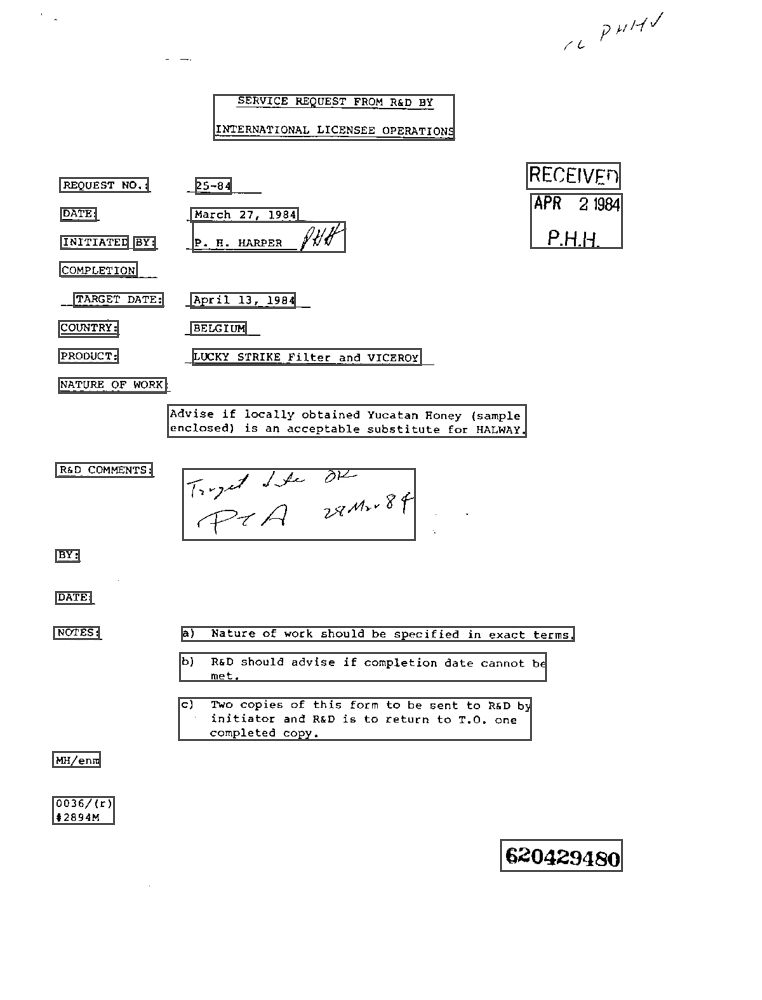

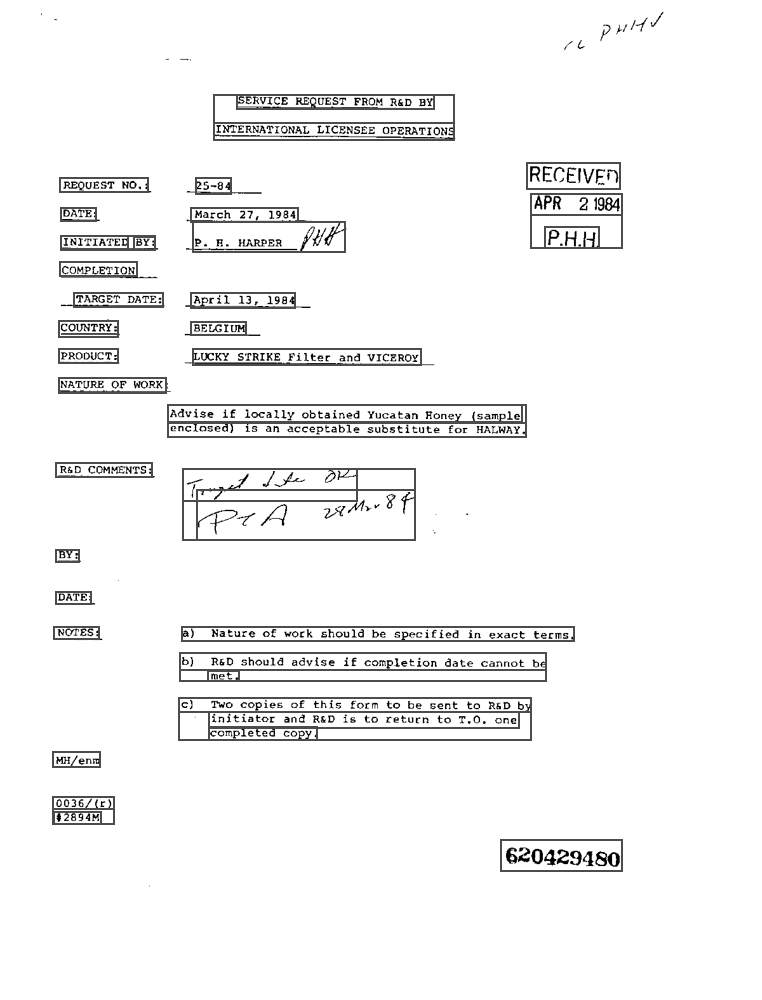

In [36]:
from PIL import ImageDraw
from PIL import Image

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def draw_boxes(image, boxes, color='red', width=2):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(unnormalize_box(box, image.width, image.height), outline=color, width=width)
    return image

image = Image.open(funsd_example['image_path'])
draw_boxes(image, funsd_example['bboxes']).show()
imgae = Image.open(custom_example['image_path'])
draw_boxes(image, custom_example['bboxes']).show()